# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, 'utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
client = Client(n_workers=32, threads_per_worker=1, memory_limit='12GB')
# client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:44929 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 32 Memory: 384.00 GB


In [ ]:
client.close()

In [3]:
path_snow_CCI = 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

path_out = 'ESA_CCI_SNOW/preprocess/scfg'
path_out_AVHRR = path_out+'/AVHRR_MERGED/v2.0'
path_out_MODIS = path_out+'/MODIS/v2.0'

In [ ]:
# for i in range(1982, 2019):
#     print(i)
#     !mkdir {path_out}'/daily/'{str(i)}

AVHRR Dimensions:
- lat: 3600
- lon: 7200

On GRICAD 32 cores (6 Go)

In [4]:
print(32/4); print(3600/4); print(7200/8)

8.0
900.0
900.0


In [32]:
str(10).zfill(2)

'10'

In [5]:
%%time

import time
from pandas.tseries.offsets import MonthEnd

chunk_lat = 900
chunk_lon = 900
delta_interp = 10 # maximum gap number of days for interpolation
latlon_round = 3 # precision for lat/lon

# for year in [str(y) for y in range(1982, 1983)]:
# for year in [str(y) for y in range(1983, 2001)]:
# for year in [str(y) for y in range(2001, 2019)]:
# for year in [str(y) for y in range(2010, 2011)]:
for year in [str(y) for y in range(2011, 2019)]:
    for month in [str(m).zfill(2) for m in range(1, 13)]:
#     for month in [str(m).zfill(2) for m in range(6, 13)]:
        start_time = time.time() # Chekc time per loop
        
        # Get previous month for interpolation
        if month == '01':
            year_prev = str(int(year) - 1)
            month_prev = '12'
        else:
            year_prev = year
            month_prev = str(int(month) - 1).zfill(2)
        
        # Get next month for interpolation
        if month == '12':
            year_next = str(int(year) + 1)
            month_next = '01'
        else:
            year_next = year
            month_next = str(int(month) + 1).zfill(2)
        
        print('\n### '+year+'-'+month+' (prev: '+year_prev+'-'+month_prev+' / next: '+year_next+'-'+month_next+')')

        # Test if there are files (ex: 1994-11 to 1995-01 no files for AVHRR)
        try:
            ds = xr.open_mfdataset(path_AVHRR+'/'+year+'/'+month+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', 
                                   parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
            ds = ds.assign_coords(lat=ds.lat.round(3), lon=ds.lon.round(3)) # round coordinates to avoid errors with concatenation
            print('Read files '+path_AVHRR+'/'+year+'/'+month+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')
        except OSError:
            print('No file to open in: '+path_AVHRR+'/'+year+'/'+month)
            continue # If there is no file, go to next iteration
        
        # Prev
        try:
            ds_prev = xr.open_mfdataset(path_AVHRR+'/'+year_prev+'/'+month_prev+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', 
                                    parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
            ds_prev = ds_prev.assign_coords(lat=ds_prev.lat.round(3), lon=ds_prev.lon.round(3)) # round coordinates to avoid errors with concatenation
            print('Read files '+path_AVHRR+'/'+year_prev+'/'+month_prev+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')
            end_date = pd.to_datetime(year_prev+'-'+month_prev) + MonthEnd(1) # Get the last day of the month
            begin_date = end_date - pd.DateOffset(days = delta_interp) # Get previous 10 days (max window for interpolation)
            concat = xr.concat([
                ds_prev.scfg.sel(time=slice(begin_date, end_date)), 
                ds.scfg
            ], dim='time').chunk({'time': -1})
            print(' => Concatenate files [prev, current]')
            
            # Next
            try:
                ds_next = xr.open_mfdataset(path_AVHRR+'/'+year_next+'/'+month_next+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', 
                                        parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
                ds_next = ds_next.assign_coords(lat=ds_next.lat.round(3), lon=ds_next.lon.round(3)) # round coordinates to avoid errors with concatenation
                print('Read files '+path_AVHRR+'/'+year_next+'/'+month_next+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')
                concat = xr.concat([
                    concat, 
                    ds_next.scfg.sel(time=slice(year_next+'-'+month_next+'-01', year_next+'-'+month_next+'-'+str(delta_interp).zfill(2)))
                ], dim='time').chunk({'time': -1})
                print(' => Concatenate files [concat, next]')
            except OSError:
                print('No file to open in: '+path_AVHRR+'/'+year_next+'/'+month_next)

        except OSError:
            print('No file to open in: '+path_AVHRR+'/'+year_prev+'/'+month_prev)
        
            # Next
            try:
                ds_next = xr.open_mfdataset(path_AVHRR+'/'+year_next+'/'+month_next+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc', 
                                        parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
                ds_next = ds_next.assign_coords(lat=ds_next.lat.round(3), lon=ds_next.lon.round(3)) # round coordinates to avoid errors with concatenation
                print('Read files '+path_AVHRR+'/'+year_next+'/'+month_next+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc')
                concat = xr.concat([
                    ds.scfg, 
                    ds_next.scfg.sel(time=slice(year_next+'-'+month_next+'-01', year_next+'-'+month_next+'-'++str(delta_interp).zfill(2)))
                ], dim='time').chunk({'time': -1})
                print('Concatenate files [current, next]')
            except OSError:
                print('No file to open in: '+path_AVHRR+'/'+year_next+'/'+month_next)
                concat = ds.scfg.chunk({'time': -1})

        scf = concat.where(concat <= 100)
        water = concat.where(concat == 210)
        ice = concat.where(concat == 215)

        # Linear temporal gapfill
        scf_interp = scf.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=delta_interp))
        print(' => Doing interpolation...')

        # Deal with attributes
        scf_interp.name = 'scfg_interp'
        del scf_interp.attrs['valid_range']
        del scf_interp.attrs['flag_values']
        del scf_interp.attrs['flag_meanings']
        scf_interp.attrs['ancillary_variables'] = 'coverage, coverage_interp'
        scf_interp.attrs['method'] = "scfg.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10))"

        # Compute time coverage
        coverage = scf.sel(time=year+'-'+month).count('time')
        coverage.name = 'coverage'
        coverage.attrs['long_name'] = 'Time Coverage'
        coverage.attrs['units'] = 'number of days'
        coverage.attrs['ancillary_variables'] = 'scfg'

        coverage_interp = scf_interp.sel(time=year+'-'+month).count('time')
        coverage_interp.name = 'coverage_interp'
        coverage_interp.attrs['long_name'] = 'Time Coverage'
        coverage_interp.attrs['units'] = 'number of days'
        coverage_interp.attrs['ancillary_variables'] = 'scfg_interp'

        ice.name = 'mask_ice'
        ice.attrs['long_name'] = 'Permanent_Snow_and_Ice'
        del ice.attrs['units']
        del ice.attrs['standard_name']
        del ice.attrs['valid_range']
        del ice.attrs['actual_range']
        ice.attrs['flag_value'] = 215
        del ice.attrs['flag_values']
        del ice.attrs['flag_meanings']
        del ice.attrs['grid_mapping']
        del ice.attrs['ancillary_variables']

        water.name = 'mask_water'
        water.attrs['long_name'] = 'Water'
        del water.attrs['units']
        del water.attrs['standard_name']
        del water.attrs['valid_range']
        del water.attrs['actual_range']
        water.attrs['flag_value'] = 210
        del water.attrs['flag_values']
        del water.attrs['flag_meanings']
        del water.attrs['grid_mapping']
        del water.attrs['ancillary_variables']

        # Combine in a new dataset
        ds_interp = scf_interp.sel(time=year+'-'+month).to_dataset()
        ds_interp['coverage'] = coverage
        ds_interp['coverage_interp'] = coverage_interp
        ds_interp['mask_ice'] = ice[0]
        ds_interp['mask_water'] = water[0]
        ds_interp.attrs = {**{'processed': 'A linear interpolation on the time dimension is performed in this dataset. ' \
            'A maximum window of 10 days is imposed, if the gap is more than 10 days, the missing values are kept. ' \
            'The temporal coverage of the data before and after interpolation is stored in the variables "coverage" and "coverage_interp". ' \
            'The permanent snow and ice, and water masks are also kept for later processing if needed. The original dataset is described below. ' \
            'Preprocess performed by Mickaël Lalande (https://mickaellalande.github.io/) on May 13, 2022. ' \
            'The same compression level is kept compared to the original dataset (zlib=True, complevel=4).'}, **ds.attrs}

        # Compression
        comp = dict(zlib=True, complevel=4)
        encoding = {var: comp for var in ds_interp.data_vars}
        ds_interp.to_netcdf(path_out_AVHRR+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc', encoding=encoding)
        print('Interpolated file saved to '+path_out_AVHRR+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')
        print("--- %s seconds ---" % (time.time() - start_time))


### 2011-01 (prev: 2010-12 / next: 2011-02)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2011/01/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2010/12/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2011/02/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [concat, next]
 => Doing interpolation...
Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2011/201101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 98.03033995628357 seconds ---

### 2011-02 (prev: 2011-01 / next: 2011-03)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2011/02/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2017/201706-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 753.1457951068878 seconds ---

### 2017-07 (prev: 2017-06 / next: 2017-08)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/07/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/06/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/08/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [concat, next]
 => Doing interpolation...


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2017/201707-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 844.5134809017181 seconds ---

### 2017-08 (prev: 2017-07 / next: 2017-09)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/08/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/07/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/09/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [concat, next]
 => Doing interpolation...


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2017/201708-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 842.5535891056061 seconds ---

### 2017-09 (prev: 2017-08 / next: 2017-10)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/09/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/08/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2017/10/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [concat, next]
 => Doing interpolation...
Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2017/201709-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 96.2786808013916 seconds ---

### 2017-10 (prev: 2017-09 / next: 2017-11)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neod

## /!\ Check 2010-06 to 08 /!\ (it was very long) + 2017 same mnths

In [ ]:
03-1984

In [ ]:
a_year = xr.open_mfdataset(path_AVHRR+'/2010/*/*.nc', parallel=True)

In [ ]:
a_year

In [ ]:
assign_coords(lat=a1.lat.round(3), lon=a1.lon.round(3)), a2.assign_coords(lat=a2.lat.round(3), lon=a2.lon.round(3))

In [38]:
a2 = a2.assign_coords(lat=a2.lat.round(3), lon=a2.lon.round(3)), a2.assign_coords(lat=a2.lat.round(3), lon=a2.lon.round(3))

In [41]:
a2[0].lat

<xarray.DataArray 'lat' (lat: 3600)>
array([-89.975, -89.925, -89.875, ...,  89.875,  89.925,  89.975])
Coordinates:
  * lat      (lat) float64 -89.97 -89.92 -89.88 -89.83 ... 89.88 89.92 89.97

In [48]:
a3.lat

<xarray.DataArray 'lat' (lat: 3600)>
array([-89.975, -89.925, -89.875, ...,  89.875,  89.925,  89.975])
Coordinates:
  * lat      (lat) float64 -89.97 -89.92 -89.88 -89.83 ... 89.88 89.92 89.97

In [49]:
a3

,Array,Chunk
Bytes,1.79 MB,57.60 kB
Shape,"(31, 3600, 2)","(1, 3600, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.57 MB,115.20 kB
Shape,"(31, 7200, 2)","(1, 7200, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [47]:
a3 = a3.assign_coords(lat=a3.lat.round(3), lon=a3.lon.round(3))

In [37]:
a1

(<xarray.Dataset>
 Dimensions:      (lat: 3600, lon: 7200, nv: 2, time: 30)
 Coordinates:
   * lon          (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
   * lat          (lat) float64 -89.97 -89.92 -89.88 -89.83 ... 89.88 89.92 89.97
   * time         (time) datetime64[ns] 2010-06-01 2010-06-02 ... 2010-06-30
 Dimensions without coordinates: nv
 Data variables:
     lat_bnds     (time, lat, nv) float64 dask.array<chunksize=(1, 3600, 2), meta=np.ndarray>
     lon_bnds     (time, lon, nv) float64 dask.array<chunksize=(1, 7200, 2), meta=np.ndarray>
     scfg         (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
     scfg_unc     (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
     spatial_ref  (time) int32 -2147483647 -2147483647 ... -2147483647
 Attributes:
     title:                      ESA CCI snow on ground product level L3C dail...
     institution:                Remote Sensing Research Group, In

In [4]:
a1 = xr.open_mfdataset(path_AVHRR+'/2010/06/*.nc', parallel=True)
a2 = xr.open_mfdataset(path_AVHRR+'/2010/07/*.nc', parallel=True)
a3 = xr.open_mfdataset(path_AVHRR+'/2010/08/*.nc', parallel=True)

In [ ]:
a2.assign_coords(lat=a2.lat.round(3))

In [6]:
xr.concat([a1.assign_coords(lat=a1.lat.round(3), lon=a1.lon.round(3)), a2.assign_coords(lat=a2.lat.round(3), lon=a2.lon.round(3))], dim='time')

,Array,Chunk
Bytes,3.51 MB,57.60 kB
Shape,"(61, 3600, 2)","(1, 3600, 2)"
Count,305 Tasks,61 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,7.03 MB,115.20 kB
Shape,"(61, 7200, 2)","(1, 7200, 2)"
Count,305 Tasks,61 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [47]:
a2.lat.round(3)

<xarray.DataArray 'lat' (lat: 3600)>
array([-89.975, -89.925, -89.875, ...,  89.875,  89.925,  89.975])
Coordinates:
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.87 89.92 89.97

In [49]:
a2.lat

<xarray.DataArray 'lat' (lat: 3600)>
array([-89.974998, -89.925003, -89.875   , ...,  89.874985,  89.924988,
        89.974983])
Coordinates:
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.87 89.92 89.97
Attributes:
    units:          degrees_north
    long_name:      WGS84 latitude coordinates, center of pixel
    standard_name:  latitude
    axis:           Y
    actual_range:   [-89.975  89.975]
    bounds:         lat_bnds

In [53]:
a2.lon

<xarray.DataArray 'lon' (lon: 7200)>
array([-179.975006, -179.925003, -179.875   , ...,  179.874969,  179.924973,
        179.974976])
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      WGS84 longitude coordinates, center of pixel
    axis:           X
    actual_range:   [-179.975  179.975]
    bounds:         lon_bnds

In [52]:
a2.assign_coords(lat=a2.lat.round(3))

,Array,Chunk
Bytes,1.79 MB,57.60 kB
Shape,"(31, 3600, 2)","(1, 3600, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.57 MB,115.20 kB
Shape,"(31, 7200, 2)","(1, 7200, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [40]:
a1.lat

<xarray.DataArray 'lat' (lat: 3600)>
array([-89.974998, -89.925003, -89.875   , ...,  89.875   ,  89.925003,
        89.974998])
Coordinates:
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
Attributes:
    units:          degrees_north
    long_name:      WGS84 latitude coordinates, center of pixel
    standard_name:  latitude
    axis:           Y
    actual_range:   [-89.975  89.975]
    bounds:         lat_bnds

In [8]:
# a = xr.open_mfdataset(path_AVHRR+'/1984/03/*.nc', parallel=True)
a = xr.open_mfdataset(path_AVHRR+'/2010/07/*.nc', parallel=True)

a

,Array,Chunk
Bytes,1.79 MB,57.60 kB
Shape,"(31, 3600, 2)","(1, 3600, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.57 MB,115.20 kB
Shape,"(31, 7200, 2)","(1, 7200, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


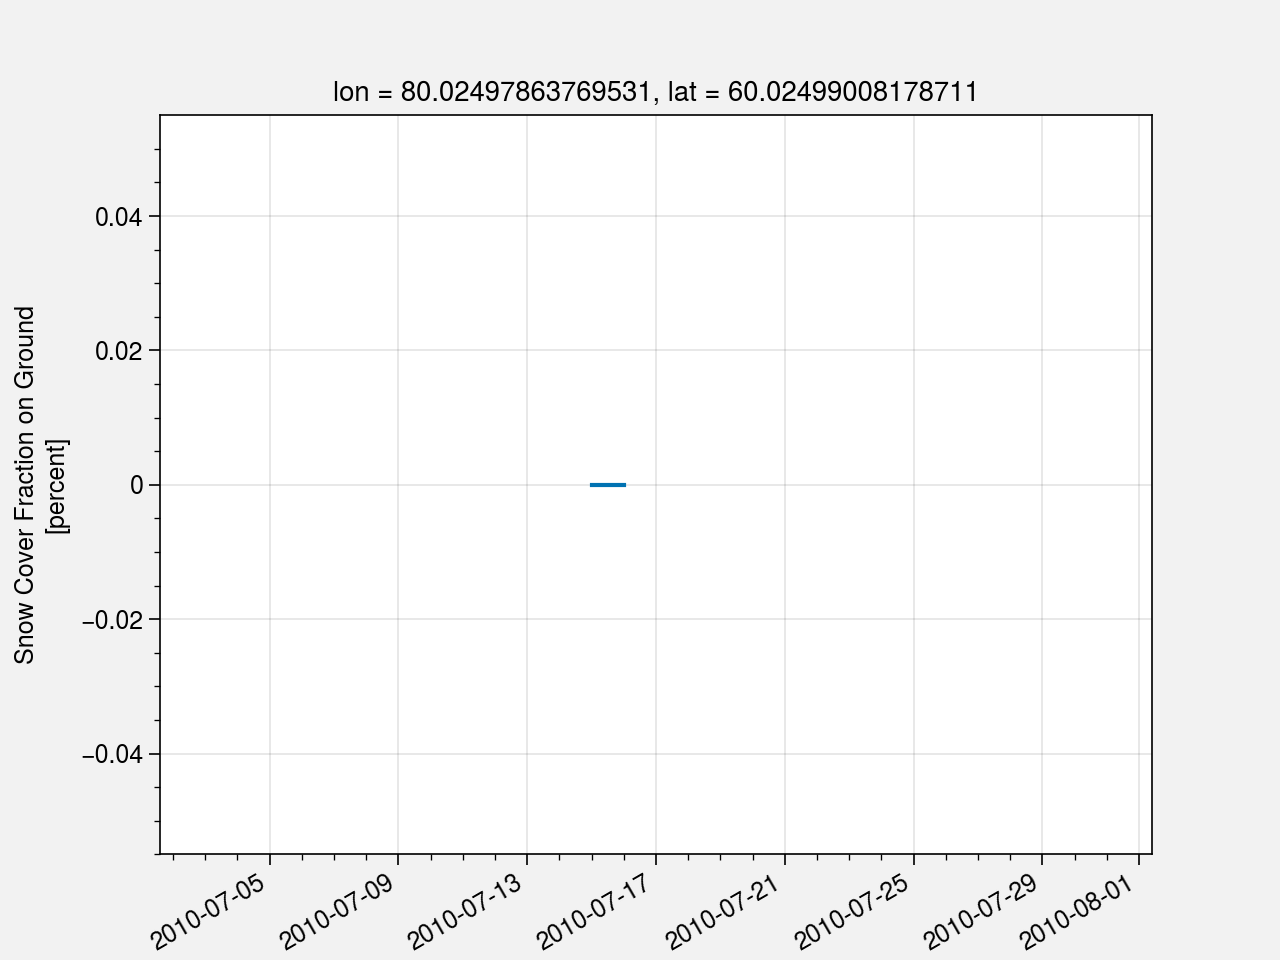

In [29]:
a.scfg.where(a.scfg <= 100).sel(lat=60, lon=80, method='nearest').plot()

In [17]:
a.time[0]

<xarray.DataArray 'time' ()>
array('2010-07-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2010-07-01
Attributes:
    axis:           T
    standard_name:  time
    long_name:      time

In [20]:
np.datetime64('2010-07-01') 

numpy.datetime64('2010-07-01')

In [22]:
pd.to_datetime('2010-07-01')  + pd.DateOffset(days = 10)

Timestamp('2010-07-11 00:00:00')

In [9]:
a.scfg.where(a.scfg <= 100).sel(lat=50, lon=100, method='nearest').values

array([ 0., nan,  0.,  0.,  0.,  0.,  0., nan, nan,  0.,  0., nan, nan,
       nan,  0.,  0., nan, nan, nan, nan, nan,  0., nan, nan,  0., nan,
       nan,  0., nan, nan,  0.], dtype=float32)

In [28]:
test

<xarray.DataArray 'scfg' (time: 31)>
array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  0., nan,
       nan,  0.,  0., nan, nan, nan, nan, nan,  0., nan, nan,  0., nan,
       nan,  0., nan, nan,  0.])
Coordinates:
    lon      float64 100.0
    lat      float64 50.02
  * time     (time) datetime64[ns] 2010-07-01 2010-07-02 ... 2010-07-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [55]:
test.interpolate_na(dim='time', method='linear', max_gap=)

<xarray.DataArray 'scfg' (time: 31)>
array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])
Coordinates:
    lon      float64 100.0
    lat      float64 50.02
  * time     (time) datetime64[ns] 2010-07-01 2010-07-02 ... 2010-07-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfg_unc

In [29]:
test.values = [ 0., np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan, np.nan, np.nan,  np.nan,  0, 0, np.nan,
       np.nan,  0.,  0., np.nan, np.nan, np.nan, np.nan, np.nan,  0., np.nan, np.nan,  0., np.nan,
       np.nan,  0., np.nan, np.nan,  0.]

In [23]:
test = a.scfg.where(a.scfg <= 100).sel(lat=50, lon=100, method='nearest').load()

In [32]:
# b = xr.open_dataset(path_out_AVHRR+'/daily/1984/198403-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')
b = xr.open_dataset(path_out_AVHRR+'/daily/2010/201007-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')


In [35]:
a

,Array,Chunk
Bytes,1.79 MB,57.60 kB
Shape,"(31, 3600, 2)","(1, 3600, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,3.57 MB,115.20 kB
Shape,"(31, 7200, 2)","(1, 7200, 2)"
Count,124 Tasks,31 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [36]:
b.lat

<xarray.DataArray 'lat' (lat: 6632)>
array([-89.974998, -89.925003, -89.875   , ...,  89.925003,  89.974983,
        89.974998])
Coordinates:
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.93 89.97 89.97
Attributes:
    units:          degrees_north
    long_name:      WGS84 latitude coordinates, center of pixel
    standard_name:  latitude
    axis:           Y
    actual_range:   [-89.975  89.975]
    bounds:         lat_bnds

In [34]:
b

<xarray.Dataset>
Dimensions:          (lat: 6632, lon: 13264, time: 31)
Coordinates:
  * lon              (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
  * lat              (lat) float64 -89.97 -89.93 -89.88 ... 89.93 89.97 89.97
  * time             (time) datetime64[ns] 2010-07-01 2010-07-02 ... 2010-07-31
Data variables:
    scfg_interp      (time, lat, lon) float64 ...
    coverage         (lat, lon) int64 ...
    coverage_interp  (lat, lon) int64 ...
    mask_ice         (lat, lon) float32 ...
    mask_water       (lat, lon) float32 ...
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-19_GAC mosaic from ESA Cloud CCI p...
    date_created:               20211114T062500Z
    history:                    20211114T062500Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                61e67305-08c8-4d3d-b152-096aeeb7f445
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         20100701-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        20100701T000000Z
    time_coverage_end:          20100701T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-19
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [33]:
b.scfg_interp.sel(lat=50, lon=100, method='nearest')

<xarray.DataArray 'scfg_interp' (time: 31)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
    lon      float64 100.0
    lat      float64 50.02
  * time     (time) datetime64[ns] 2010-07-01 2010-07-02 ... 2010-07-31
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    actual_range:         [  0 100]
    grid_mapping:         spatial_ref
    ancillary_variables:  coverage, coverage_interp
    method:               scfg.interpolate_na('time', method='linear', max_ga...

In [27]:
b.scfg_interp.sel(lat=50, lon=100, method='nearest').reindex(time=pd.date_range('1984-03-01', '1984-03-31', freq='D'))

<xarray.DataArray 'scfg_interp' (time: 31)>
array([ 0.   ,    nan,  0.   ,  0.   ,  4.375,  8.75 , 13.125, 17.5  ,
       21.875, 26.25 , 30.625, 35.   , 17.5  ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ])
Coordinates:
  * time     (time) datetime64[ns] 1984-03-01 1984-03-02 ... 1984-03-31
    lon      float64 100.0
    lat      float64 50.03
Attributes:
    long_name:            Snow Cover Fraction on Ground
    units:                percent
    standard_name:        surface_snow_area_fraction
    actual_range:         [  0 100]
    grid_mapping:         spatial_ref
    ancillary_variables:  coverage, coverage_interp
    method:               scfg.interpolate_na('time', method='linear', max_ga...

## Check

In [33]:
test = xr.open_dataset('ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1994/199401-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')
test

<xarray.Dataset>
Dimensions:          (lat: 3600, lon: 7200, time: 31)
Coordinates:
  * lon              (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat              (lat) float64 -89.97 -89.93 -89.88 ... 89.88 89.93 89.97
  * time             (time) datetime64[ns] 1994-01-01 1994-01-02 ... 1994-01-31
Data variables:
    scfg_interp      (time, lat, lon) float64 ...
    coverage         (lat, lon) int64 ...
    coverage_interp  (lat, lon) int64 ...
    mask_ice         (lat, lon) float32 ...
    mask_water       (lat, lon) float32 ...
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-11_GAC mosaic from ESA Cloud CCI p...
    date_created:               20211111T130400Z
    history:                    20211111T130400Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                1322e03c-9eba-44ee-8c67-0858564226fd
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19940101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19940101T000000Z
    time_coverage_end:          19940101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-11
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [39]:
clim_orig = ds.scfg.where(ds.scfg <= 100).mean('time').load()

In [40]:
test_clim = test.scfg_interp.mean('time').load()

/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


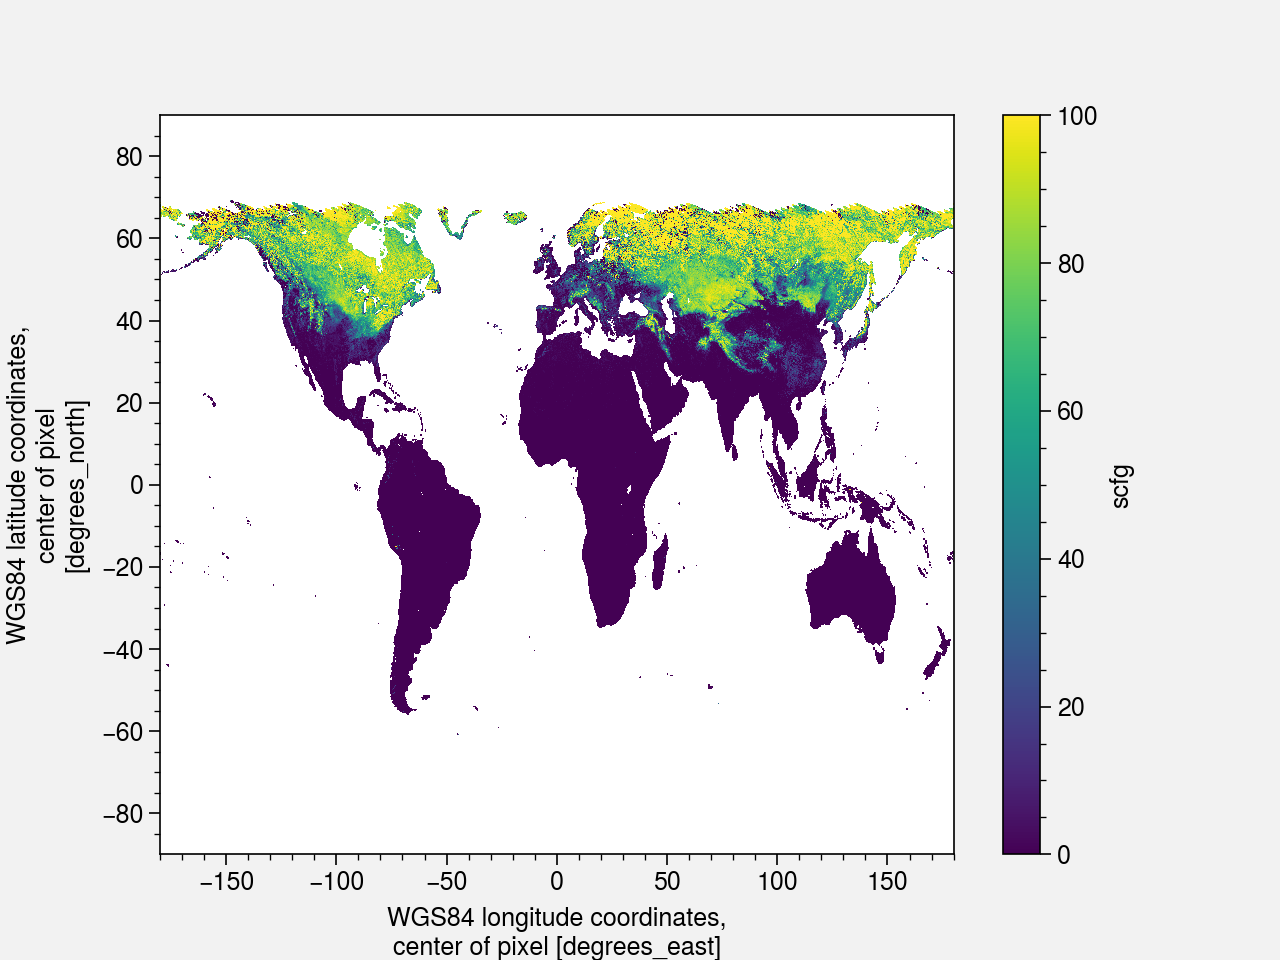

In [41]:
clim_orig.plot()

/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


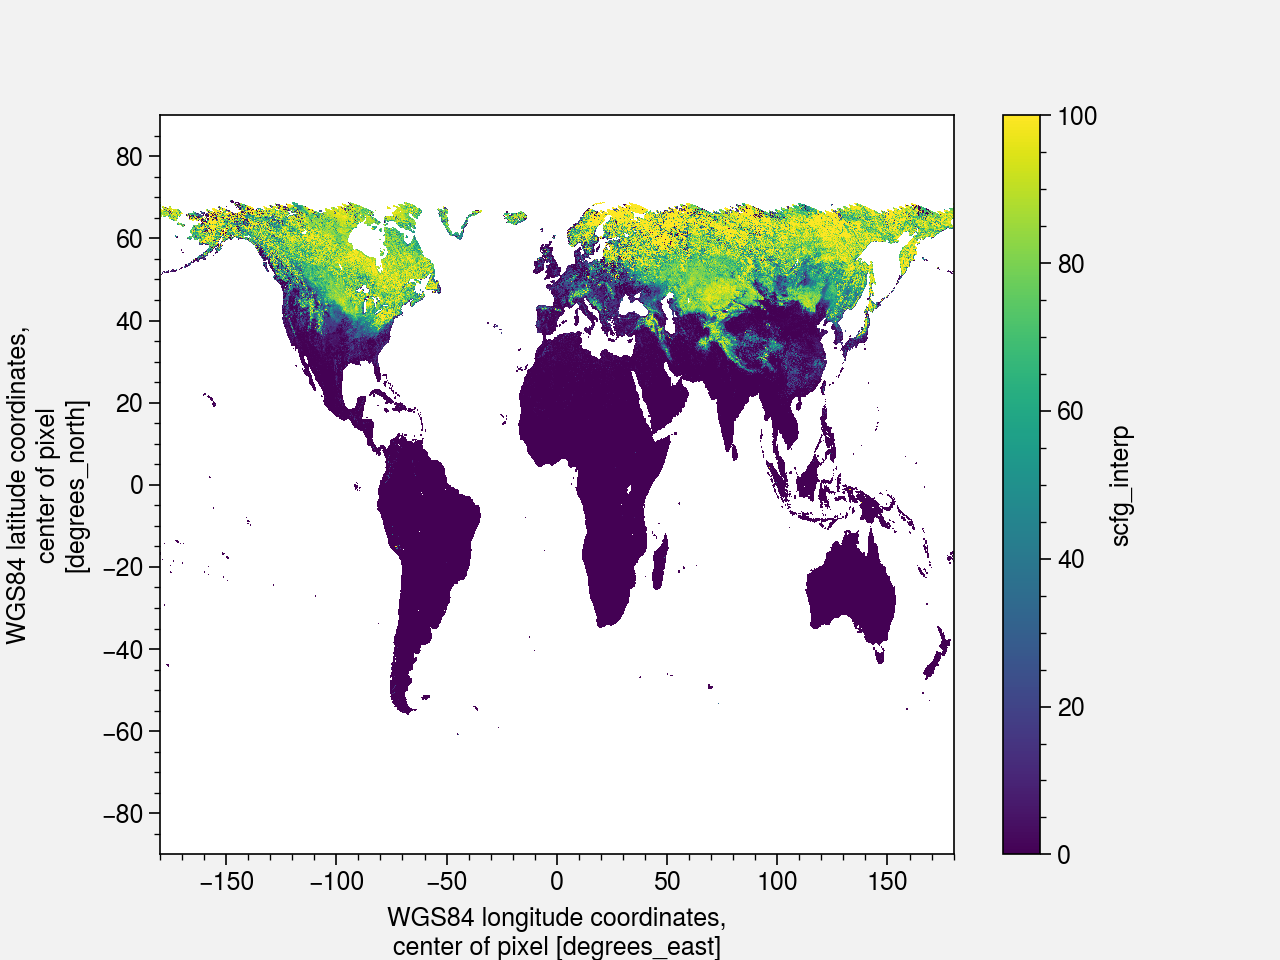

In [34]:
test.scfg_interp.mean('time').plot()

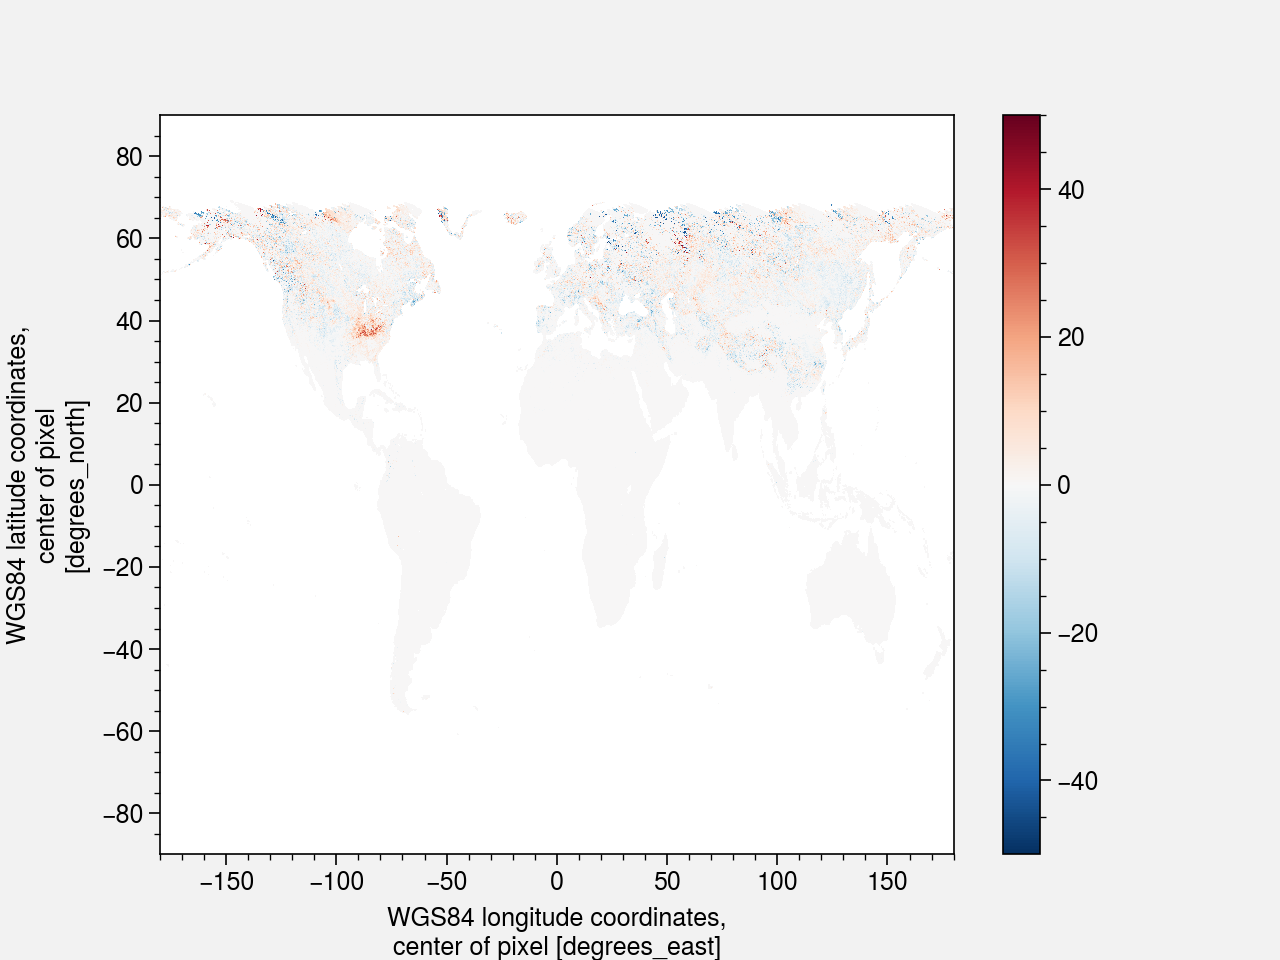

In [45]:
(clim_orig - test_clim).plot()

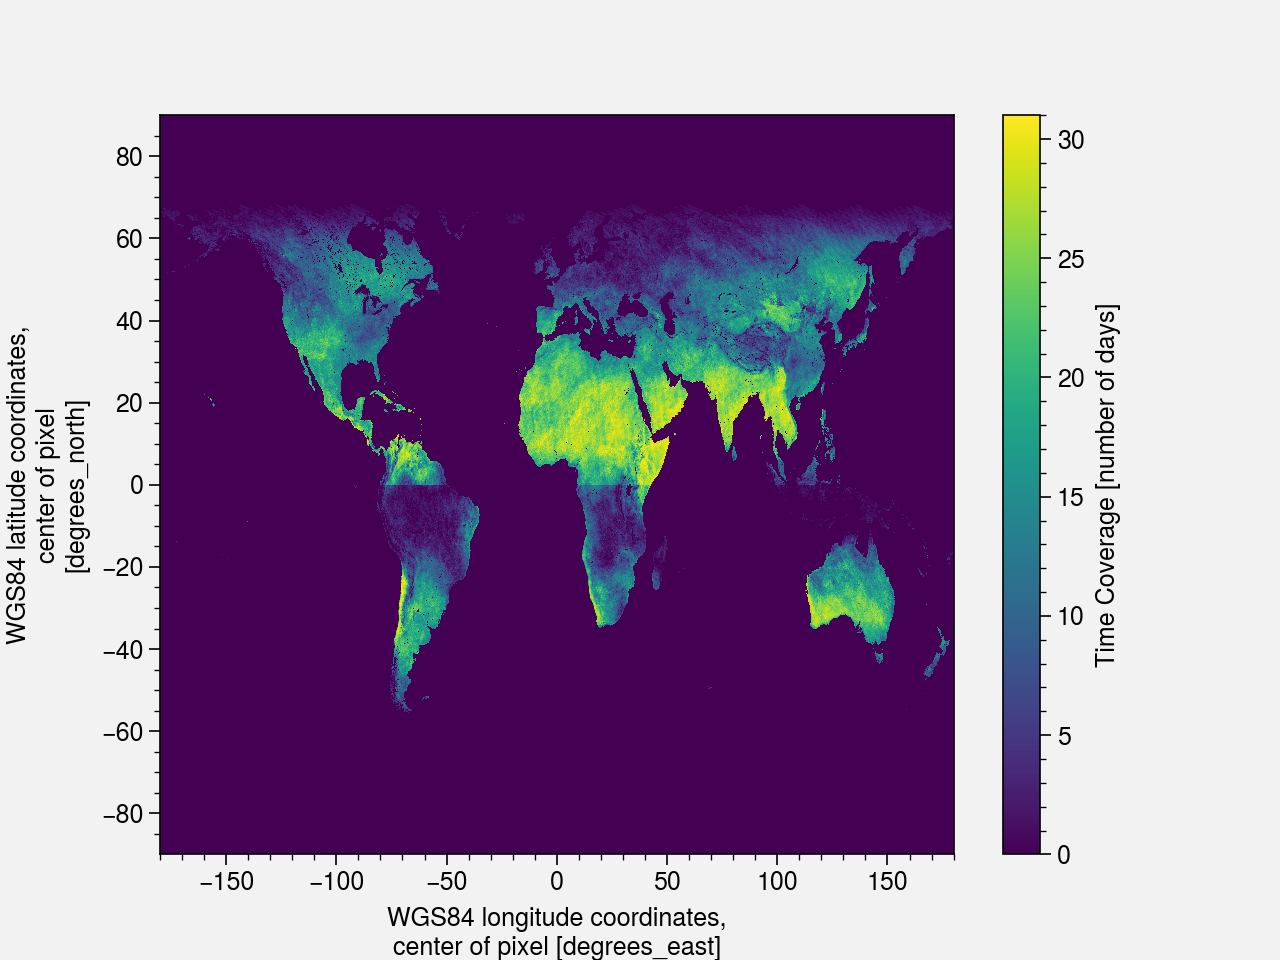

In [35]:
test.coverage.plot(vmax=31)

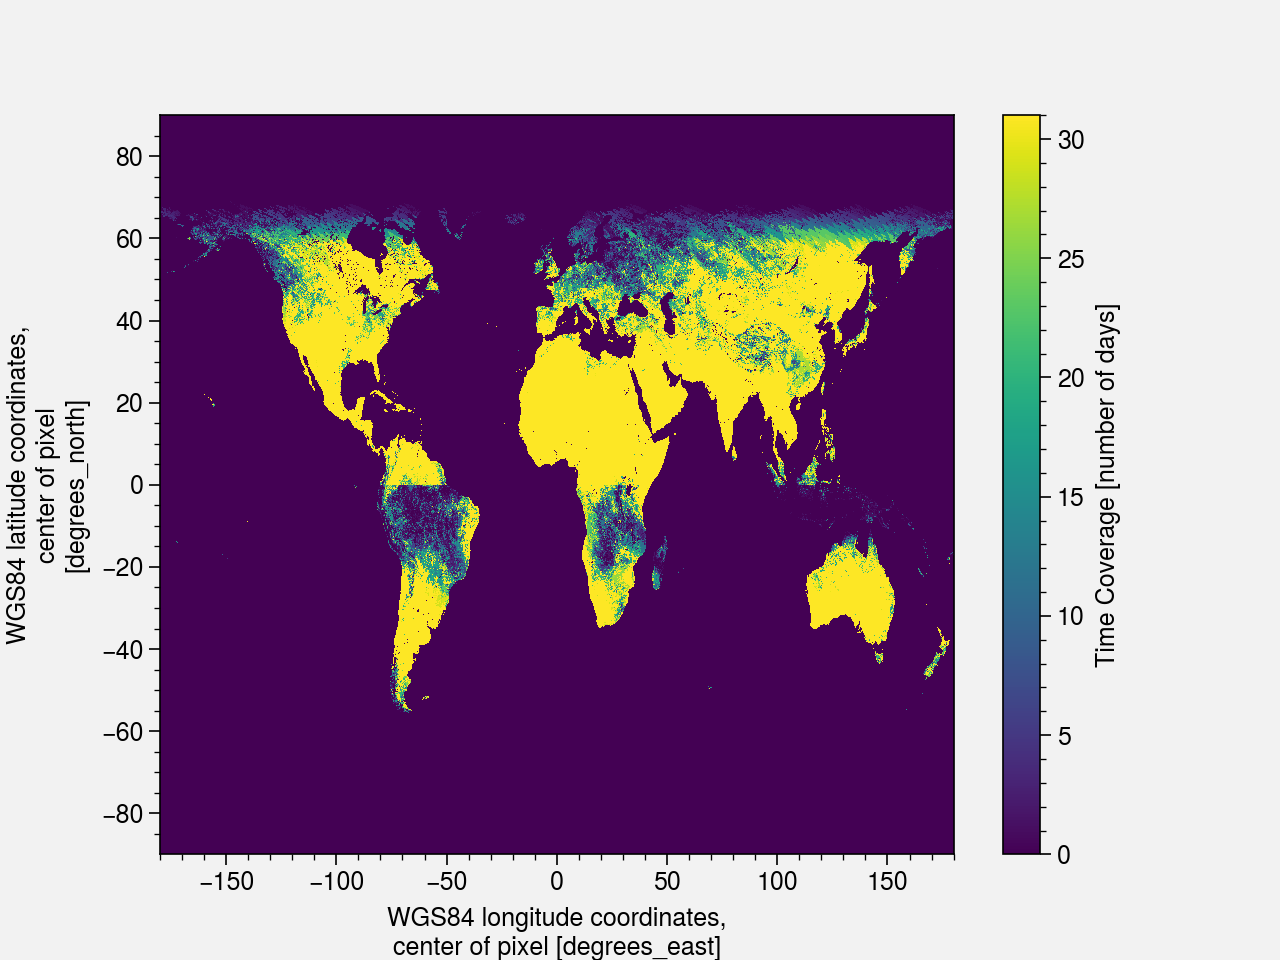

In [36]:
test.coverage_interp.plot(vmax=31)

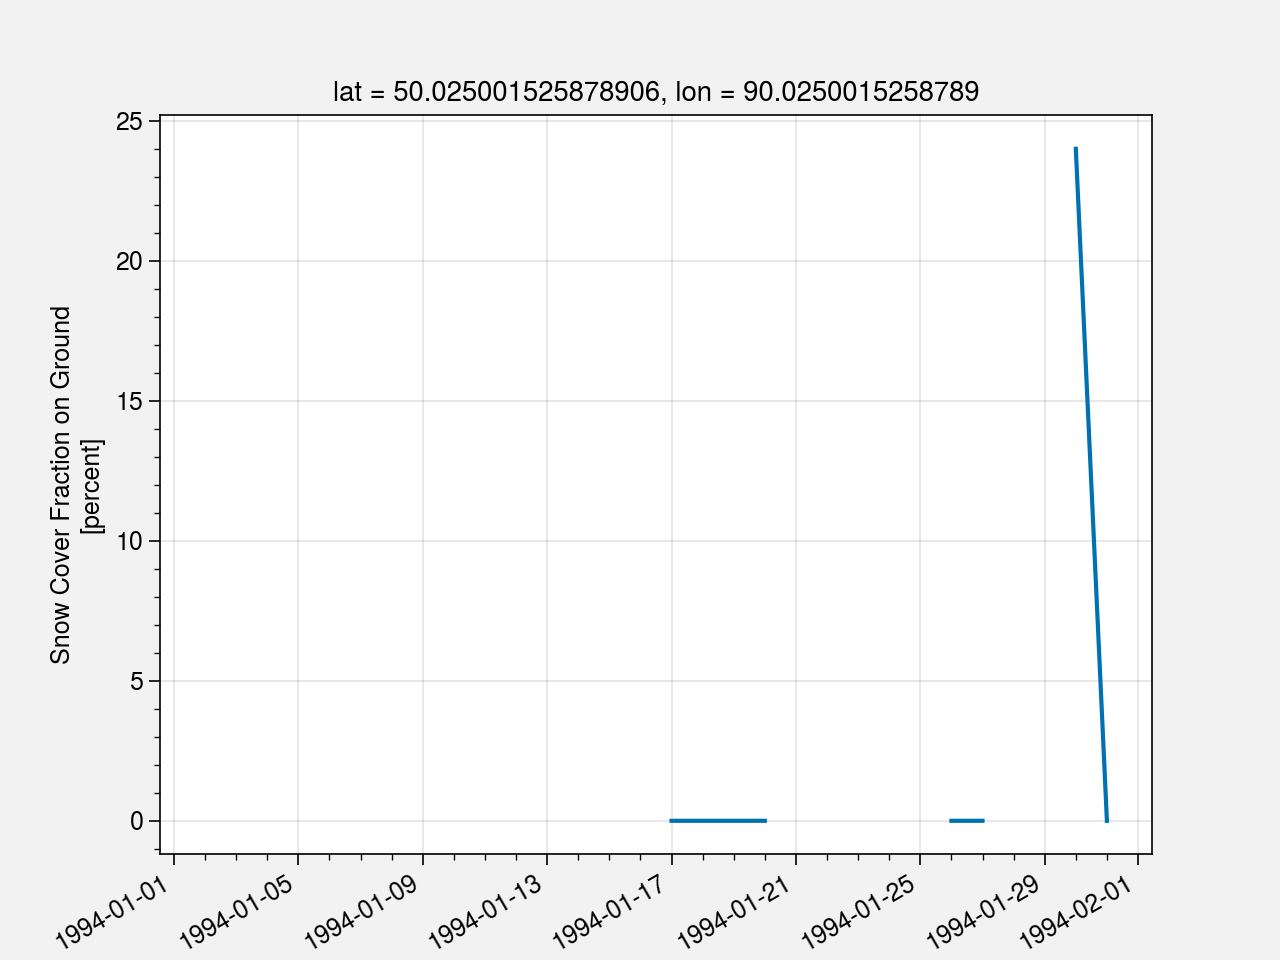

In [51]:
ds.scfg.where(ds.scfg <= 100).sel(lat=50, lon=90, method='nearest').plot()

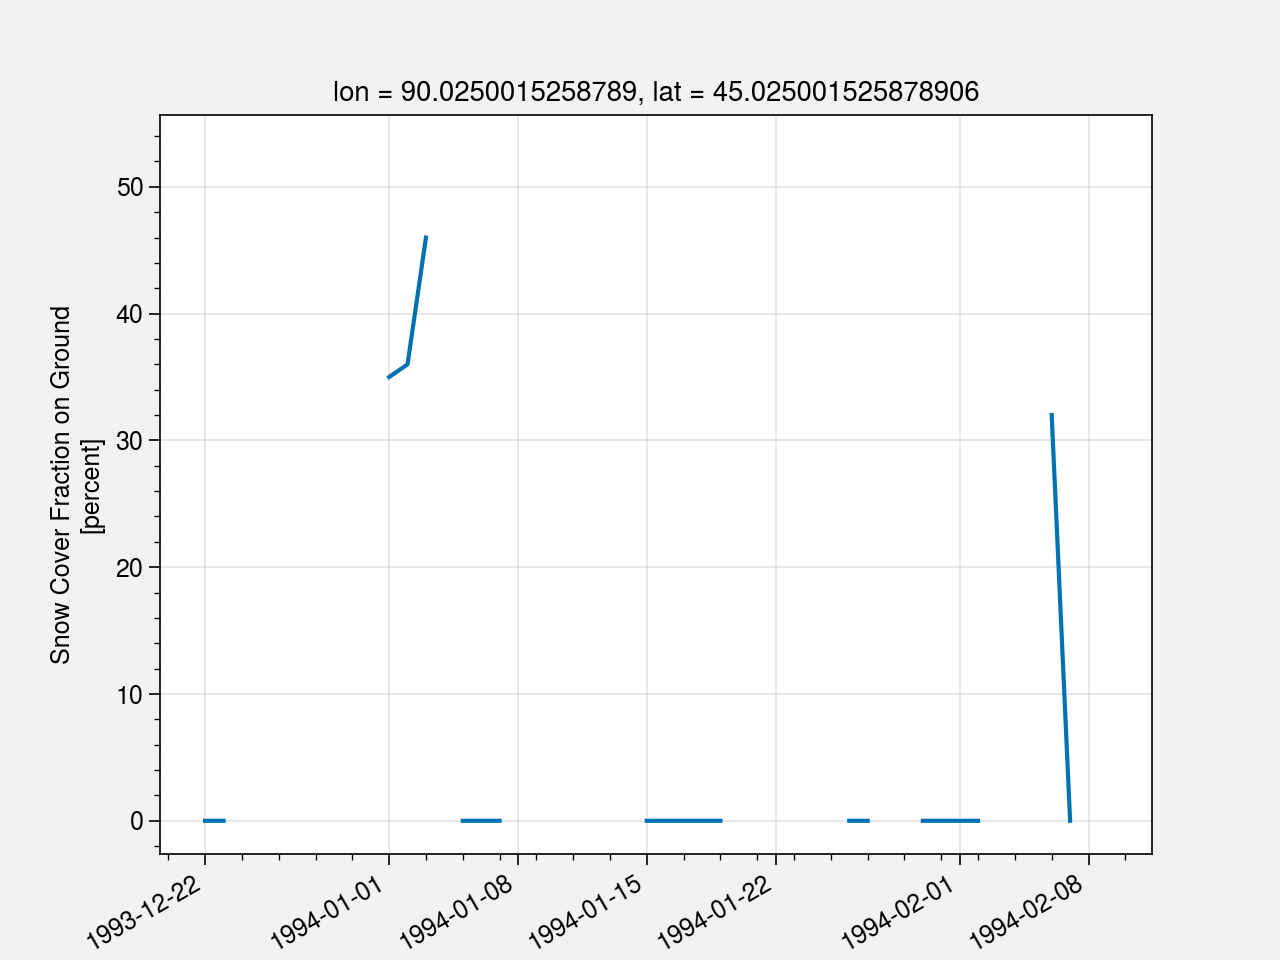

In [59]:
scf.sel(lat=45, lon=90, method='nearest').plot()

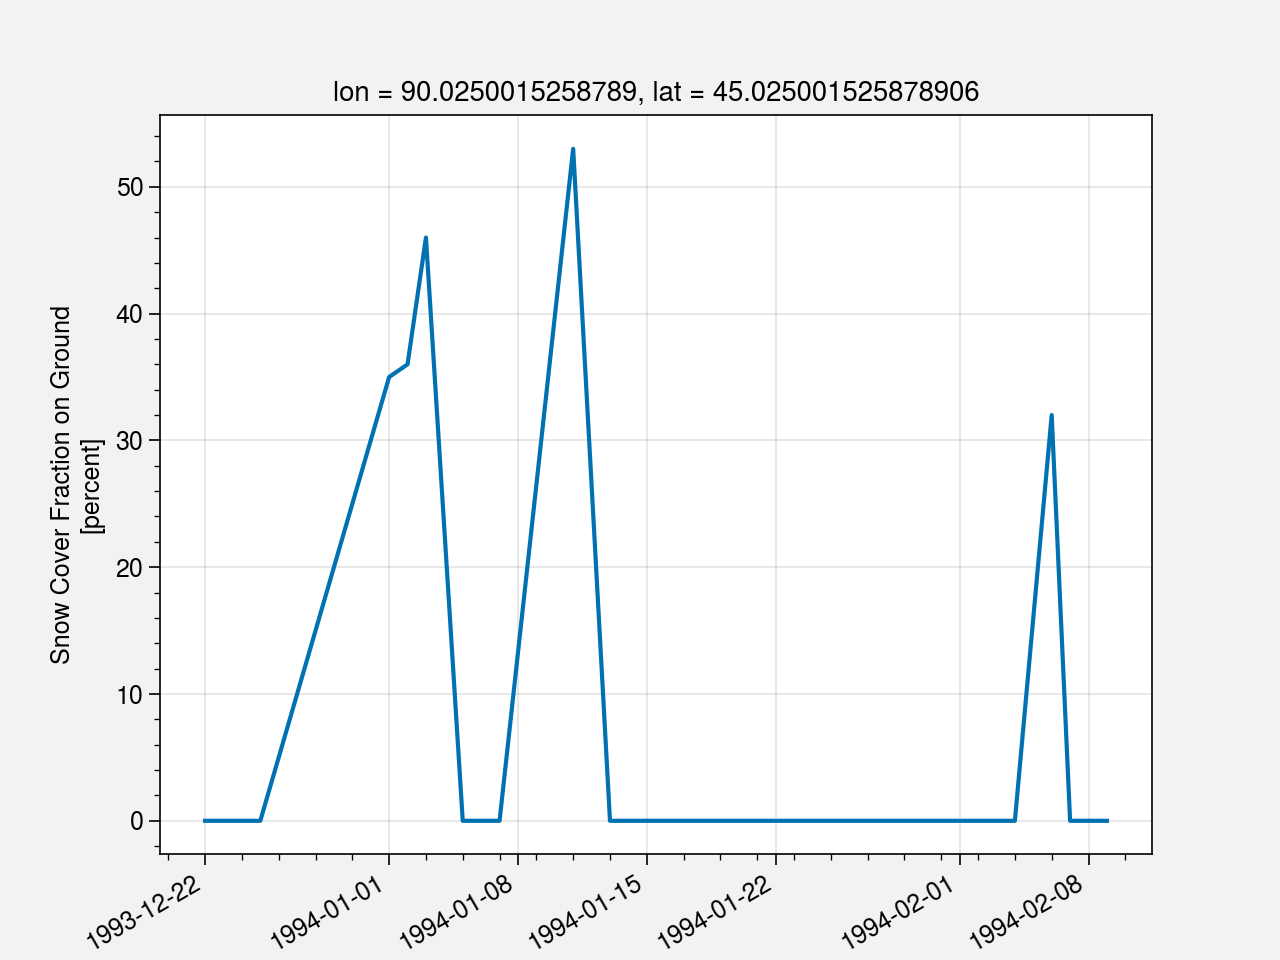

In [60]:
scf.sel(lat=45, lon=90, method='nearest').interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10)).plot()

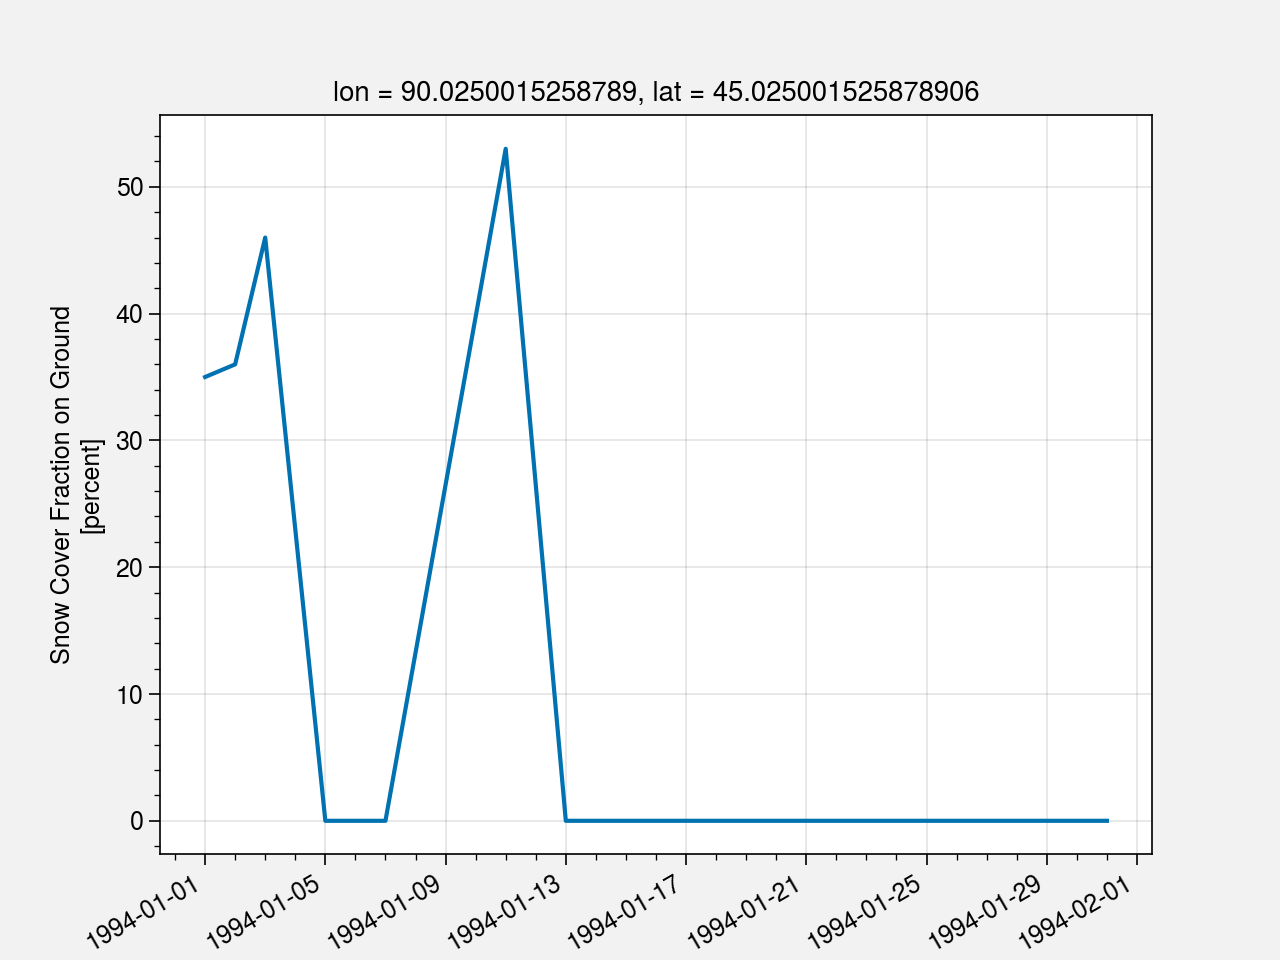

In [54]:
test.scfg_interp.sel(lat=45, lon=90, method='nearest').plot()